In [48]:
import collections
import logging 
import pathlib
import time 
import warnings 
import datetime 

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests

In [50]:
from tqdm.auto import tqdm
import requests_cache 
import nglview
import pypdb

In [51]:
import biotite.database.rcsb as rcsb
from rdkit.Chem import Draw 
from rdkit.Chem import PandasTools

In [54]:
from opencadd.structure.superposition.api import align, METHODS
from opencadd.structure.core import Structure

In [55]:
logger = logging.getLogger("opencadd")
logger.setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [56]:
requests_cache.install_cache("rcsb_pdb", backend="memory")

In [57]:
HERE = pathlib.Path(_dh[-1])
DATA = HERE / "data"

In [58]:
#We use EGFR as query protein
# The UniProt ID of EGFR is P00533
uniprot_id = "P00533"

In [59]:
#We define our criteria
uniprot_id = "P00533"
before_deposition_date = "2020-01-01T00:00:00Z"
experimental_method = "X-RAY DIFFRACTION"
max_resolution = 3.0
n_chains = 1
min_ligand_molecular_weight = 100.0

In [60]:
#We set up each query
query_by_uniprot_id = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=uniprot_id,
)
query_by_deposition_date = rcsb.FieldQuery(
    "rcsb_accession_info.deposit_date", less=before_deposition_date
)
query_by_experimental_method = rcsb.FieldQuery("exptl.method", exact_match=experimental_method)
query_by_resolution = rcsb.FieldQuery(
    "rcsb_entry_info.resolution_combined", less_or_equal=max_resolution
)
query_by_polymer_count = rcsb.FieldQuery(
    "rcsb_entry_info.deposited_polymer_entity_instance_count", equals=n_chains
)
query_by_ligand_mw = rcsb.FieldQuery(
    "chem_comp.formula_weight", molecular_definition=True, greater=min_ligand_molecular_weight
)

In [61]:
#We perform each of the queries alone and check the number of matches per condition
print(f"Number of structures with UniProt ID {uniprot_id}: {rcsb.count(query_by_uniprot_id)}")
time.sleep(0.1)  # wait shortly to not overload the API
print(
    f"Number of structures deposited before {before_deposition_date}: {rcsb.count(query_by_deposition_date)}"
)
time.sleep(0.1)
print(
    f"Number of structures resolved by {experimental_method}: {rcsb.count(query_by_experimental_method)}"
)
time.sleep(0.1)
print(
    f"Number of structures with resolution less than or equal to {max_resolution}: {rcsb.count(query_by_resolution)}"
)
time.sleep(0.1)
print(f"Number of structures with only {n_chains} chain: {rcsb.count(query_by_polymer_count)}")
time.sleep(0.1)
print(
    f"Number of structures with ligand of more than or equal to {min_ligand_molecular_weight} Da: {rcsb.count(query_by_ligand_mw)}"
)

Number of structures with UniProt ID P00533: 262
Number of structures deposited before 2020-01-01T00:00:00Z: 166330
Number of structures resolved by X-RAY DIFFRACTION: 168846
Number of structures with resolution less than or equal to 3.0: 160713
Number of structures with only 1 chain: 72252
Number of structures with ligand of more than or equal to 100.0 Da: 1195685


In [62]:
query = rcsb.CompositeQuery(
    [
        query_by_uniprot_id,
        query_by_deposition_date,
        query_by_experimental_method,
        query_by_resolution,
        query_by_polymer_count,
        query_by_ligand_mw,
    ],
    "and",
)
pdb_ids = rcsb.search(query)
print(f"Number of matches: {len(pdb_ids)}")
print("Selected PDB IDs:")
print(*pdb_ids)

Number of matches: 110
Selected PDB IDs:
6S9C 6S9D 5HG9 5HG7 5HG8 5HG5 6JXT 2EB2 2EB3 3UG2 3UG1 5GMP 5U8L 4HJO 6S8A 4LI5 6JX4 6JX0 6JWL 5GTZ 5J9Y 5J9Z 4LQM 4G5J 5XDL 5XDK 4I23 4I22 5UG8 5UG9 4I1Z 6S89 5UGB 5UGC 5UGA 5HCX 5CAV 5CAU 1M17 5HCY 5HCZ 2RGP 5X26 4RJ4 5X27 5C8M 5C8N 5C8K 4RJ8 4RJ7 5X28 4RJ6 4WKQ 5ZWJ 3BEL 3GOP 1M14 5CAS 5CAP 5CAQ 2GS2 5CAN 6D8E 5CAO 5CAL 4ZAU 4JRV 3POZ 4JR3 5EM5 5EDQ 5EDR 5EM8 5EDP 5EM6 5EM7 3VJO 2J5F 3VJN 5FED 5HIC 6JRK 5HIB 6JRJ 2ITV 4WRG 2ITW 2ITX 2ITZ 5FEE 2ITN 2ITP 4JQ8 2ITQ 4JQ7 2ITT 2ITU 6JRX 3W2S 3W33 3W2R 3W32 3W2Q 3W2P 3W2O 5GNK 5XGM 1XKK 6JZ0 5ZTO


In [63]:
import redo
@redo.retriable(attempts=10, sleeptime=2)
def describe_one_pdb_id(pdb_id):
    """Fetch meta information from PDB."""
    described = pypdb.describe_pdb(pdb_id)
    if described is None:
        print(f"! Error while fetching {pdb_id}, retrying ...")
        raise ValueError(f"Could not fetch PDB id {pdb_id}")
    return described

In [64]:
pdbs_data = [describe_one_pdb_id(pdb_id) for pdb_id in tqdm(pdb_ids)]

  0%|          | 0/110 [00:00<?, ?it/s]

In [65]:
pdbs_data[12]["entry"]

{'id': '5U8L'}

In [66]:
resolution = pd.DataFrame(
    [
        [pdb_data["entry"]["id"], pdb_data["rcsb_entry_info"]["resolution_combined"][0]]
        for pdb_data in pdbs_data
    ],
    columns=["pdb_id", "resolution"],
).sort_values(by="resolution", ignore_index=True)
resolution

,pdb_id,resolution
0,5UG9,1.330
1,5HG8,1.420
2,5UG8,1.460
3,3POZ,1.500
4,5HG5,1.520
...,...,...
105,2ITX,2.980
106,5GTZ,2.999
107,2J5F,3.000
108,5C8K,3.000


In [67]:
top_num = 6  # Number of top structures

In [68]:
selected_pdb_ids = resolution[:top_num]["pdb_id"].to_list()
print(f"Selected PDB IDs: {selected_pdb_ids}")

Selected PDB IDs: ['5UG9', '5HG8', '5UG8', '3POZ', '5HG5', '5UGC']


In [69]:
def get_ligands(pdb_id):
    """
    RCSB has not provided a new endpoint for ligand information yet. As a
    workaround we are obtaining extra information from ligand-expo.rcsb.org,
    using HTML parsing. Check Talktorial T011 for more info on this technique!
    """
    pdb_info = _fetch_pdb_nonpolymer_info(pdb_id)
    ligand_expo_ids = [
        nonpolymer_entities["pdbx_entity_nonpoly"]["comp_id"]
        for nonpolymer_entities in pdb_info["data"]["entry"]["nonpolymer_entities"]
    ]

    ligands = {}
    for ligand_expo_id in ligand_expo_ids:
        ligand_expo_info = _fetch_ligand_expo_info(ligand_expo_id)
        ligands[ligand_expo_id] = ligand_expo_info

    return ligands


def _fetch_pdb_nonpolymer_info(pdb_id):
    """
    Fetch nonpolymer data from rcsb.org.
    Thanks @BJWiley233 and Rachel Green for this GraphQL solution.
    """
    query = (
        """{
          entry(entry_id: "%s") {
            nonpolymer_entities {
              pdbx_entity_nonpoly {
                comp_id
                name
                rcsb_prd_id
              }
            }
          }
        }"""
        % pdb_id
    )

    query_url = f"https://data.rcsb.org/graphql?query={query}"
    response = requests.get(query_url)
    response.raise_for_status()
    info = response.json()
    return info


def _fetch_ligand_expo_info(ligand_expo_id):
    """
    Fetch ligand data from ligand-expo.rcsb.org.
    """
    r = requests.get(f"http://ligand-expo.rcsb.org/reports/{ligand_expo_id[0]}/{ligand_expo_id}/")
    r.raise_for_status()
    html = BeautifulSoup(r.text)
    info = {}
    for table in html.find_all("table"):
        for row in table.find_all("tr"):
            cells = row.find_all("td")
            if len(cells) != 2:
                continue
            key, value = cells
            if key.string and key.string.strip():
                info[key.string.strip()] = "".join(value.find_all(string=True))

    # Postprocess some known values
    info["Molecular weight"] = float(info["Molecular weight"].split()[0])
    info["Formal charge"] = int(info["Formal charge"])
    info["Atom count"] = int(info["Atom count"])
    info["Chiral atom count"] = int(info["Chiral atom count"])
    info["Bond count"] = int(info["Bond count"])
    info["Aromatic bond count"] = int(info["Aromatic bond count"])
    return info

In [70]:
columns = [
    "@structureId",
    "@chemicalID",
    "@type",
    "@molecularWeight",
    "chemicalName",
    "formula",
    "InChI",
    "InChIKey",
    "smiles",
]
rows = []
for pdb_id in selected_pdb_ids:
    ligands = get_ligands(pdb_id)
    # If several ligands contained, take largest (first in results)
    ligand_id, properties = max(ligands.items(), key=lambda kv: kv[1]["Molecular weight"])
    rows.append(
        [
            pdb_id,
            ligand_id,
            properties["Component type"],
            properties["Molecular weight"],
            properties["Name"],
            properties["Formula"],
            properties["InChI descriptor"],
            properties["InChIKey descriptor"],
            properties["Stereo SMILES (OpenEye)"],
        ]
    )

In [71]:
ligands = pd.DataFrame(rows, columns=columns)
ligands

,@structureId,@chemicalID,@type,@molecularWeight,chemicalName,formula,InChI,InChIKey,smiles
0,5UG9,8AM,NON-POLYMER,445.494,"N-[(3R,4R)-4-fluoro-1-{6-[(3-methoxy-1-methyl-...",C20 H28 F N9 O2,InChI=1S/C20H28FN9O2/c1-6-15(31)23-13-9-29(7-1...,MJLFLAORJNTNDV-CHWSQXEVSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...
1,5HG8,634,NON-POLYMER,377.400,N-[3-({2-[(1-methyl-1H-pyrazol-4-yl)amino]-7H-...,C19 H19 N7 O2,InChI=1S/C19H19N7O2/c1-3-16(27)22-12-5-4-6-14(...,YWNHZBNRKJYHTR-UHFFFAOYSA-N,CCC(=O)Nc1cccc(c1)Oc2c3cc[nH]c3nc(n2)Nc4cnn(c4)C
2,5UG8,8BP,NON-POLYMER,415.468,"N-[(3R,4R)-4-fluoro-1-{6-[(1-methyl-1H-pyrazol...",C19 H26 F N9 O,InChI=1S/C19H26FN9O/c1-5-15(30)24-14-9-28(8-13...,CGULPICMFDDQRH-ZIAGYGMSSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...
3,3POZ,03P,NON-POLYMER,547.957,N-{2-[4-({3-chloro-4-[3-(trifluoromethyl)pheno...,C26 H25 Cl F3 N5 O3,"InChI=1S/C26H25ClF3N5O3/c1-25(2,37)14-22(36)31...",ZYQXEVJIFYIBHZ-UHFFFAOYSA-N,CC(C)(CC(=O)NCCn1ccc2c1c(ncn2)Nc3ccc(c(c3)Cl)O...
4,5HG5,633,NON-POLYMER,471.554,N-{3-[(2-{[4-(4-methylpiperazin-1-yl)phenyl]am...,C26 H29 N7 O2,InChI=1S/C26H29N7O2/c1-3-23(34)28-19-5-4-6-21(...,JZXKYJJXGSXWTQ-UHFFFAOYSA-N,CCC(=O)Nc1cccc(c1)Oc2c3cc[nH]c3nc(n2)Nc4ccc(cc...
5,5UGC,8BS,NON-POLYMER,417.441,"N-[(3R,4R)-4-fluoro-1-{6-[(3-methoxy-1-methyl-...",C18 H24 F N9 O2,InChI=1S/C18H24FN9O2/c1-5-13(29)21-11-8-28(6-1...,XWNKXCUQRQRAFF-GHMZBOCLSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...


In [72]:
ligands.to_csv(DATA / "PDB_top_ligands.csv", header=True, index=False)
#sending the top 6 ortho ligands with the higest resolutions
# for .csv file stores it data

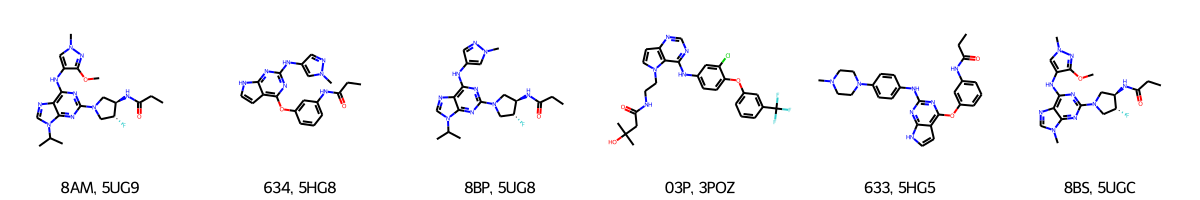

In [73]:
PandasTools.AddMoleculeColumnToFrame(ligands, "smiles")
Draw.MolsToGridImage(
    mols=list(ligands.ROMol),
    legends=list(ligands["@chemicalID"] + ", " + ligands["@structureId"]),
    molsPerRow=top_num,
)
#Draw top ligand molecules

## Align PDB structures and extract ligands

In [74]:
pairs = collections.OrderedDict(zip(ligands["@structureId"], ligands["@chemicalID"]))
pairs

OrderedDict([('5UG9', '8AM'),
             ('5HG8', '634'),
             ('5UG8', '8BP'),
             ('3POZ', '03P'),
             ('5HG5', '633'),
             ('5UGC', '8BS')])

In [75]:
structures = [Structure.from_pdbid(pdb_id) for pdb_id in pairs]
structures

[<Universe with 2664 atoms>,
 <Universe with 2716 atoms>,
 <Universe with 2632 atoms>,
 <Universe with 2536 atoms>,
 <Universe with 2849 atoms>,
 <Universe with 2542 atoms>]